In [4]:
from IPython.core.debugger import set_trace
import unittest
tc = unittest.TestCase('__init__')

import numpy as np
from numpy.linalg import inv

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use = "default"
# mathjax docs: https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference

In [5]:
def p(*args):
    for arg in args:
        print(arg)
        print(" ")

# The Problem

Given $A \in \mathbb{R}^{mxn} \text{ and } b \in \mathbb{R}^n$ in the equation:

$Ax = b$
  
We want to solve for $x$

In [6]:
def ex_1():
    return (np.array([
        [4, -1, 2 ,-1],
        [2, 6, 3, -3],
        [1, 1, 5, 0],
        [1, -1, 4, 7]
    ], dtype=np.float64), 
    np.array([[-8, -20, -2, 4]], dtype=np.float64).T,
    np.array([[2, 2, 3, -7]], dtype=np.float64).T)


def ex_2():
    # slide 115
    return (
        np.array([
            [.2, .1, 1, 1, 0],
            [.1, 4, -1, 1, -1],
            [1, -1, 60, 0, -1],
            [1, 1, 0 , 8, 4],
            [0, -1, -2, 4, 700]    
        ]),
        np.array([1,2,3,4,5], dtype=np.float64).T,
        np.array([7.859713071, 0.4229264082, -.07359223906, -.5406430164, .01062616286], dtype=np.float64).T
    )

def ex_3():
    return (
        np.array([
            [4., 3., 0.],
            [3., 4., -1.],
            [0., -1., 4.]
        ]),
        np.array([24., 30., -24.]),
        np.array([3, 4, -5])
    )

def ex_4():
    return (
        np.array([
            [3.3330, 15920, -10.333],
            [2.2220, 16.710, 9.6120],
            [1.5611, 5.1791, 1.6852]
        ]),
        np.array([15913, 28.544, 8.4254]),
        np.array([1, 1, 1])
    )

def ex(number):
    if number == 1:
        return ex_1()
    elif number == 2:
        return ex_2()
    elif number == 3:
        return ex_3()
    elif number == 4:
        return ex_4()

In [121]:
def run_test(example_num, generate_plot, methods, iterations=-1):
    if not isinstance(methods, list):
        raise Exception("parameter `methods` must be a list of method declarations.")
        
    A, b, x = ex(example_num)
    errors = []
    max_err_length = -np.inf
    for i, method in enumerate(methods):
        if iterations > 0:
            est_x, iter_vals = np.array(method(A, b, iterations))
        else:
            est_x, iter_vals = np.array(method(A, b))
        
        error = np.diff(x - np.array(iter_vals), axis=1)
        
        errors_string = "\n".join(["i = {} -> norm(X - estimate) = {}".format(i, str(s)) for i, s in enumerate(np.linalg.norm(error, axis=1).tolist())])
        #p("{} errors for each iteration:\n{}".format(method.__name__, errors_string))
        errors.append(error)

    if generate_plot:
        m_names = []
        plot = plt.figure(figsize=(12, 7))
        
        for i, e in enumerate(errors):
            method_name = " ".join(methods[i].__name__.split("_"))
            plt.plot(np.linalg.norm(e, axis=1), label=method_name)
            m_names.append(method_name)
            
        plt.legend()
        plt.ylabel("norm")
        plt.xlabel("iteration")
        plt.title(", ".join(m_names) + " (example {})".format(example_num))
        plot.savefig("{}.pdf".format("_".join(m_names).replace(" ", "_")))
        plt.show()
    
    return errors

In [124]:
def run_test(example_num, generate_plot, methods, iterations=-1):
    if not isinstance(methods, list):
        raise Exception("parameter `methods` must be a list of method declarations.")
        
    A, b, x = ex(example_num)
    errors = []
    max_err_length = -np.inf
    for method in methods:
        if iterations > 0:
            x, iter_vals = np.array(method(A, b, iterations))
        else:
            x, iter_vals = np.array(method(A, b))
        error = x - np.array(iter_vals)
        errors.append(error)

    if generate_plot:
        m_names = []
        plot = plt.figure(figsize=(12, 7))
        
        for i, e in enumerate(errors):
            method_name = " ".join(methods[i].__name__.split("_"))
            plt.plot(np.linalg.norm(e, axis=1), label=method_name)
            m_names.append(method_name)
            
        plt.legend()
        plt.ylabel("norm")
        plt.xlabel("iteration")
        plt.title(", ".join(m_names) + " (example {})".format(example_num))
        plot.savefig("1.pdf")
        plt.show()
    
    return errors

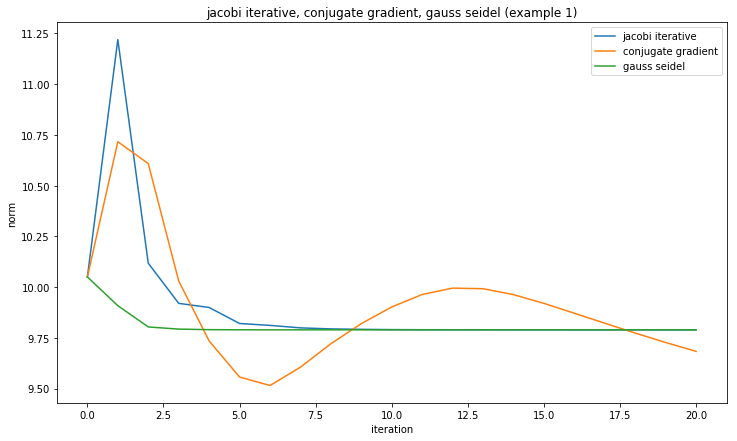

In [122]:
r = run_test(1, True, [jacobi_iterative, conjugate_gradient, gauss_seidel], 20)

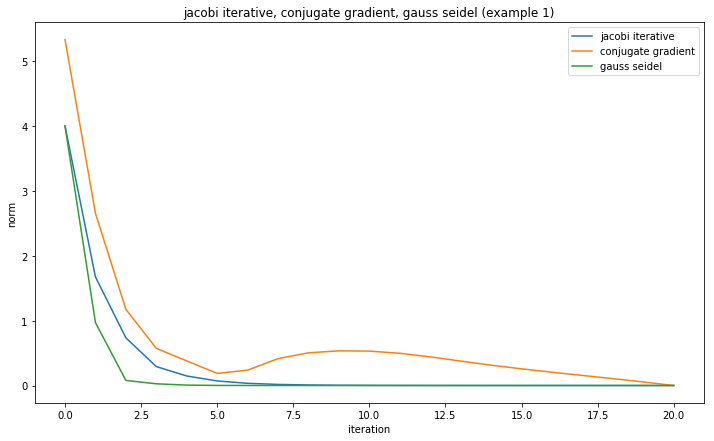

In [125]:
r = run_test(1, True, [jacobi_iterative, conjugate_gradient, gauss_seidel], 20)

# Gausse Elimination

In [10]:
def swap_rows(m, row_index_1, row_index_2):
    cpy = m.copy()
    cpy[[row_index_1, row_index_2]] = cpy[[row_index_2, row_index_1]]
    return cpy

def swap_rows_if_zero(m, b, pivot_row, pivot_col):
    if m[pivot_row, pivot_col] != 0:
        return m, b
    
    nonzero_indices = np.where(m[pivot_row:, pivot_col] != 0)
    if nonzero_indices[0].size == 0:
        return -1, -1
    m = swap_rows(m, pivot_row, nonzero_indices[0][0] + pivot_row)
    b = swap_rows(b, pivot_row, nonzero_indices[0][0] + pivot_row)
    return m, b

def swap_rows_pivot(m, b, pivot_row, pivot_col): 
    col = m[pivot_row:, pivot_col]
    max_indices = np.where(col == max(col))
    max_i = max_indices[0][0]
    if col[max_i] == 0:
        return -1, -1
    m = swap_rows(m, pivot_row, max_i + pivot_row)
    b = swap_rows(b, pivot_row, max_i + pivot_row)
    
    return m, b

def scale_matrix(m, b):
    rows = m.shape[0]
    for i in range(rows):
        row = np.array(m[i])
        m[i] = row/max(row)
        b[i] = b[i]/max(row)
    return m, b

In [11]:
def forward_elimination(A, b, partial_pivoting=True, scaled=True):
    rows, columns = A.shape
    if scaled:
        A, b = scale_matrix(A, b)
        
    for j in range(columns): 
        if partial_pivoting:
            A, b = swap_rows_pivot(A, b, j, j)
        else:
            A, b = swap_rows_if_zero(A, b, j, j)
            
        if type(A) is int:
            return "System does not have unique solution", False
        a_jj = A[j, j]
        for i in range(1 + j, rows):
            a_ij = A[i, j]
            A[i] = A[i] - (A[j]*a_ij/a_jj) 
            b[i] = b[i] - (b[j]*a_ij/a_jj)
            
    return A, b

In [12]:
# A -> n x m matrix, b -> 1 x m matrix
def backward_substitution(A, b):
    x = []
    rows, columns = A.shape
    A = A[::-1, ::-1]
    b = b[::-1]
    for i in range(rows):
        x.append((b[i] - sum(A[i, :i]))/A[i,i])
        A[:,i] = A[:, i]*x[i]
        
        
    return x[::-1]


In [13]:
def gauss(A, b, partial_pivoting=True, scaled=True):
    A, b = forward_elimination(A, b, partial_pivoting, scaled)
    if type(A) is str:
        print(A)
        return [0]
    return backward_substitution(A, b)

No Pivoting

In [14]:
A, b, x = ex_4()

p_x = gauss(A, b, partial_pivoting=False, scaled=False)
p(p_x, x)

[1.0000000000001614, 1.0, 0.9999999999999687]
 
[1 1 1]
 


Partial Pivoting

In [15]:
A, b, x = ex_4()
p_x = gauss(A, b, scaled=False)

p(p_x, x)

[1.0000000000001614, 1.0, 1.0000000000000264]
 
[1 1 1]
 


Scaled Partial Pivoting

In [16]:
A, b, x = ex_3()
p_x = gauss(A, b)

p(p_x, x)

[2.999999999999999, 4.000000000000001, -4.999999999999999]
 
[ 3  4 -5]
 


# Jacobi Iterative Method

In [17]:
def jacobi_iterative(A, b, num_iterations = -1):
    D = np.diagflat(np.diag(A))
    R = A - D
    L = np.tril(R)
    U = np.triu(R)
    inverse_D = inv(D)
    
    converg_thresh = .001
    error = np.inf
    prev_x = np.zeros(b.shape)
    iterations = [prev_x]
    i = 0
    
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        x = inverse_D @ (b - (R @ prev_x))
        iterations.append(x)
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    return x, iterations

In [18]:
A, b, x = ex(4)
print(A)
p("Estimation:", jacobi_iterative(A,b)[0], "x:", x)

[[ 3.3330e+00  1.5920e+04 -1.0333e+01]
 [ 2.2220e+00  1.6710e+01  9.6120e+00]
 [ 1.5611e+00  5.1791e+00  1.6852e+00]]
Estimation:
 
[1.16100397e+155 6.58605230e+152 4.06024608e+153]
 
x:
 
[1 1 1]
 


/usr/local/Cellar/python3/3.5.0/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [19]:
iters = []
for i in range(2, 5):
    A, b, x = ex(i)
    for j in range(1,5):
        p_x, ite = jacobi_iterative(A, b, j * 10)
        p("Example {} ({} iterations)".format(i, j*10), np.linalg.norm(x - ite, axis=1))

Example 2 (10 iterations)
 
[7.88997972 3.04665788 5.8724788  2.05913853 4.2918644  1.38021813
 3.14011304 0.91765583 2.30102584 0.60461545 1.68882905]
 
Example 2 (20 iterations)
 
[7.88997972 3.04665788 5.8724788  2.05913853 4.2918644  1.38021813
 3.14011304 0.91765583 2.30102584 0.60461545 1.68882905 0.39450179
 1.24147335 0.25501134 0.91404444 0.16384175 0.67399249 0.1056577
 0.4976984  0.06989086 0.36800066]
 
Example 2 (30 iterations)
 
[7.88997972 3.04665788 5.8724788  2.05913853 4.2918644  1.38021813
 3.14011304 0.91765583 2.30102584 0.60461545 1.68882905 0.39450179
 1.24147335 0.25501134 0.91404444 0.16384175 0.67399249 0.1056577
 0.4976984  0.06989086 0.36800066 0.04904851 0.27241238 0.03748321
 0.20183479 0.03094634 0.1496278  0.02671854 0.11093804 0.02344382
 0.0822123 ]
 
Example 2 (40 iterations)
 
[7.88997972 3.04665788 5.8724788  2.05913853 4.2918644  1.38021813
 3.14011304 0.91765583 2.30102584 0.60461545 1.68882905 0.39450179
 1.24147335 0.25501134 0.91404444 0.163841

# Gauss-Seidel

In [20]:
def gauss_seidel(A, b, num_iterations = -1):
    L = np.tril(A)
    U = A - L
    x0 = np.random.random(b.shape)
    inv_L = inv(L) 
    
    converg_thresh = .001
    error = np.inf
    prev_x = np.zeros(b.shape)
    iterations = [prev_x]
    i = 0
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        x = inv_L @ (b - (U @ prev_x))
        iterations.append(x)
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    
    return x, iterations

In [21]:
# slide 85/86
A = np.array([
    [4, 3, 0],
    [3, 4, -1],
    [0, -1, 4]
])
b = np.array([24, 30, -24])
x = np.array([3,4,-5])

p("Estimation:", gauss_seidel(A, b)[0], "x:", x)

Estimation:
 
[ 3.00682121  3.99431566 -5.00142109]
 
x:
 
[ 3  4 -5]
 


In [22]:
# iters = []
# for i in range(1, 5):
#     A, b, x = ex(i)
#     for j in range(1,5):
#         p_x, ite = gauss_seidel(A, b, j * 10)
#         p("Example {} ({} iterations)".format(i, j*10), np.linalg.norm(x - ite, axis=1))

# Successive Over-Relaxation

In [71]:
def successive_over_relax(A, b, w=1.2, num_iterations = -1):
    D = np.diagflat(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    
    converg_thresh = .001
    
    error = np.inf
    i = 0
    prev_x = np.ones(b.shape)
    iterations = [prev_x]
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        # https://en.wikipedia.org/wiki/Successive_over-relaxation
        x = inv(D + (w * L)) @ ((w * b) - (((w * U) + ((w-1)*D)) @ prev_x))
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        iterations.append(x)
        i += 1
    
    return x, iterations

In [88]:
iters = []
for i in range(2, 4):
    A, b, x = ex(i)
    p_x, ite = gauss_seidel(A, b, 90)
    p("EXAMPLE {}".format(i), "Est ({} iterations):".format(len(ite)), p_x, "X:", x, "Err: ", np.linalg.norm(x - ite, axis=1))
#     for j in range(1,5):
#         p_x, ite = successive_over_relax(A, b, j * 10)



EXAMPLE 2
 
Est (91 iterations):
 
[ 7.86275553  0.42288764 -0.07382067 -0.5410192   0.0106276 ]
 
X:
 
[ 7.85971307  0.42292641 -0.07359224 -0.54064302  0.01062616]
 
Err: 
 
[7.88997972e+00 2.88416589e+00 2.06947307e+00 1.47120086e+00
 1.04559110e+00 7.42849406e-01 5.27507381e-01 3.74333352e-01
 2.65379788e-01 1.87880500e-01 1.32754829e-01 9.35436493e-02
 6.56525545e-02 4.58135221e-02 3.17020005e-02 2.16645424e-02
 1.45250781e-02 9.44713975e-03 5.83593152e-03 3.26896441e-03
 1.44870562e-03 2.38709168e-04 8.13711049e-04 1.46066893e-03
 1.92532648e-03 2.25665307e-03 2.49256855e-03 2.66046483e-03
 2.77992666e-03 2.86491650e-03 2.92537761e-03 2.96838742e-03
 2.99898223e-03 3.02074532e-03 3.03622594e-03 3.04723760e-03
 3.05507035e-03 3.06064189e-03 3.06460498e-03 3.06742396e-03
 3.06942913e-03 3.07085542e-03 3.07186995e-03 3.07259159e-03
 3.07310490e-03 3.07347002e-03 3.07372973e-03 3.07391446e-03
 3.07404587e-03 3.07413933e-03 3.07420582e-03 3.07425311e-03
 3.07428675e-03 3.07431067e-03 

In [89]:
iters = []
for i in range(2, 4):
    A, b, x = ex(i)
    p_x, ite = successive_over_relax(A, b, 1.2)
    p("EXAMPLE {}".format(i), "Est ({} iterations):".format(len(ite)), p_x, "X:", x, "Err: ", np.linalg.norm(x - ite, axis=1))
#     for j in range(1,5):
#         p_x, ite = successive_over_relax(A, b, j * 10)



EXAMPLE 2
 
Est (14 iterations):
 
[ 7.85413921  0.42273772 -0.07369662 -0.54005107  0.01062286]
 
X:
 
[ 7.85971307  0.42292641 -0.07359224 -0.54064302  0.01062616]
 
Err: 
 
[7.20372953e+00 1.47204960e+01 5.41349828e+00 3.58194025e+00
 1.84439341e+00 1.03689096e+00 5.64848546e-01 3.10028569e-01
 1.69067344e-01 9.16389642e-02 4.90300759e-02 2.55926018e-02
 1.26999750e-02 5.60935586e-03]
 
EXAMPLE 3
 
Est (8 iterations):
 
[ 3.00087313  3.99950821 -5.00017935]
 
X:
 
[ 3  4 -5]
 
Err: 
 
[7.00000000e+00 3.39066203e+00 3.68807280e-01 1.34873506e-01
 1.25405034e-02 9.03503676e-03 1.71029620e-03 1.01802830e-03]
 


# Iterative Refinement  

In [25]:
def iterative_refinement(A, b, method, num_iterations=2):
    x = np.array(method(A,b)) 
    for k in range(num_iterations):
        r = b - A @ x
        print(r)
        y = np.array(method(A, r))
        print(y)
        x = x + y
    
    return x

A, b, x = ex_3()
x_ref = iterative_refinement(A, b, gauss)

p("estimated:", x_ref, "actual", x)

[ 0.0000000e+00  0.0000000e+00 -8.8817842e-16]
[ 4.44089210e-16 -5.92118946e-16 -1.03620816e-15]
[0. 0. 0.]
[0. 0. 0.]
estimated:
 
[ 3.  4. -5.]
 
actual
 
[ 3  4 -5]
 


# Conditioned Conjugate Gradient

In [90]:
def conjugate_gradient(A, b, num_iterations = -1):
    x = np.ones(b.shape)
    iterations = [x]
    prev_r = b - (A @ x)
    v = prev_r
    i = 0
    while i < num_iterations if num_iterations > 0 else not np.allclose(prev_r, np.zeros(prev_r.shape)):
        Av = A @ v
        
        t = (prev_r.T @ prev_r) / (v.T @ Av)
        x = x + (t * v)
        iterations.append(x)
        
        r = prev_r - (t * Av)
        s = (r.T @ r) / (prev_r.T @ prev_r)
        v = r + (s * v)
        
        prev_r = r
        
        i += 1
    
    return x, iterations

In [27]:
p("Estimation:", conjugate_gradient(A, b)[0], "x:", x)

Estimation:
 
[ 3.  4. -5.]
 
x:
 
[ 3  4 -5]
 


In [28]:
def cc_gradient(C, A, b, num_iterations = -1):
    x = np.ones(b.shape)
    r = b - (A @ x)
    iterations = [x]
    prev_w = inv(C) @ r
    v = inv(C.T) @ prev_w
    i = 0
    while i < num_iterations if num_iterations > 0 else not np.allclose(r, np.zeros(r.shape)):
        Av = A @ v
        
        t = (prev_w.T @ prev_w) / (v.T @ Av)
        x = x + (t * v)
        iterations.append(x)
        
        r = r - (t * Av)
        
        w = inv(C) @ r
        s = (w.T @ w) / (prev_w.T @ prev_w)
        v = (inv(C.T) @ w) + (s * v)
        
        prev_w = w
        
        i += 1
    
    return x, iterations

In [17]:
p("Estimation:", cc_gradient(np.diagflat(np.diag(A)), A, b)[0], "x:", x)

Estimation:
 
[ 3.  4. -5.]
 
x:
 
[ 3  4 -5]
 
